In [7]:
#path = 'saved_model_1020_5class_combined_RMSprop_100_0.0001_ENCFRZ_False'
#path = 'saved_model_1020_RMSprop_100_0.0001_BNone_classweights_P3_S10_EncoderTrained'
#path = 'saved_model_1021_(960, 1152)_0.001'
#path = 'saved_model_1021_(960, 1152)_0.0005'
path = 'saved_model_1025_(1200, 1392)_0.001'

In [8]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

import glob
import cv2
import gc

from tqdm import tqdm
import time

2.2.0


In [3]:
"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [9]:
IMG_SIZE = (1200, 1392)

In [27]:
def display(display_list, idx=None, only_inference=False, fig_size=15, title=['Ground Truth Mask', 'Pushed', 'Stamped']):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        a = np.array(display_list)
        a = a.astype(np.float32) * 255.0
        
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list))
        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        #title = ['Ground Truth Mask', 'Pushed', 'Stamped', 'hole']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')

        plt.show()
    

In [11]:
def create_mask(pred_mask, num=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
    if test_mode:
        print("In testing Mode...")
        for i in range(num):
            pred_mask = model.predict(x, batch_size=1)
            display([x[i], y[i], create_mask(pred_mask, num=i)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [12]:
def draw_and_count(img, contours, label = '', draw_type = 'contour', show=True):
    # img : original image
    # contours: Contours found from opencv code
    assert label in ['push', 'stamp', 'hole'], "label must be either 'push' or 'stamp'"
    assert draw_type in ['bbox', 'contour'], "draw type must be either 'bbox' or 'contour'"
    
    if label=='push': val = 220
    if label=='stamp': val = 150
    if label=='hole': val = 250
        
        
    count = 0
    area = []
    width_height = []
    
    for idx, cnt in enumerate(contours):
        a = cv2.contourArea(cnt)
        if a < val:
            continue
        
        area.append(a)
        count += 1
        
        if draw_type == 'bbox':
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(125,125,0),2)
            width_height.append([w,h])
            print("{} #{} has width of {} and height of {}".format(label, idx, w, h))
            
        elif draw_type == 'contour':
            cv2.drawContours(img, [cnt], 0, (125, 125, 0), 2) 
            
    if show:        
        display([img], fig_size=8)
        print("{} {} found. Area: {}".format(count,label,area))

        
    return img, area, width_height, count

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1.0, 0.0, 1.0], 4: [1.0, 0.23529412, 0.23529412], 5: [1.0, 1.0, 0.0]}


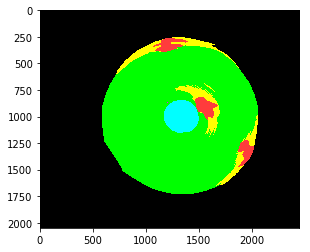

In [13]:
import cv2
from itertools import product
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448

colors = np.unique(tf.reshape(mask, [-1,3]), axis=0) 
#mask = tf.image.grayscale_to_rgb(mask)
plt.imshow(mask)

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

# WITHOUT TRT

In [14]:
model = tf.keras.models.load_model(path)

In [318]:
"""
time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(glob.glob("images/test/*.bmp"))):
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, IMG_SIZE) 
    
    image = tf.expand_dims(image,0)
    pred_mask.append(model(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0] # H,W,4
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1)) + np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, label='stamp', show=False)
    
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, label='push', show=False)
    
    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                 stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ", (np.mean(time_list) * 1000).round(3), "ms")
"""

100%|██████████| 46/46 [00:04<00:00, 10.30it/s]

Average inference time is:  96.475 ms


In [15]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [17]:
time_list = []
pred_mask = []

img_loc = glob.glob("Original_Image/*.png")
    
    
for idx,image in enumerate(tqdm(img_loc)):
    
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, IMG_SIZE) #960,1152
    
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.flip_left_right(image)
    
    image = tf.expand_dims(image,0)
    pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4
    
    ex = pred_mask[idx][0][0]
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1)) + np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    hole = np.round(tf.expand_dims(ex[:,:,4], -1))
    
    # STAMP
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, label='stamp', show=False)
    
    # PUSH
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, label='push', show=False)


    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                  stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ",(np.mean(time_list) * 1000).round(3), "ms")

100%|██████████| 80/80 [00:13<00:00,  5.84it/s]

Average inference time is:  170.164 ms


In [31]:
gc.collect()

train_x = []
train_y = []

for img in glob.glob("Original_Image/*.png"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE) #960,1152
    n = tf.image.rgb_to_grayscale(n)

    n = tf.image.flip_left_right(n)

    train_x.append(n)
    
    dir = "Mask_Image/" # "/".join(img.split("/")[:-1]) + "/Mask_Image/"
    file_name = img.split("/")[-1] # img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name) # imread(dir+file_name+".png")

    #dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    #file_name = img.split("/")[-1].split('.')[0]

    #y = cv2.imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot
    
    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot #0,1,2,3
    bbb = tf.image.resize(bb, IMG_SIZE) #960,1152
    
    bbb = tf.image.flip_left_right(bbb)

    train_y.append(bbb)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(80, 1200, 1392, 1)
(80, 1200, 1392, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [13]:
"""
np.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), 
                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))
"""

"\nnp.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), \n                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))\n"

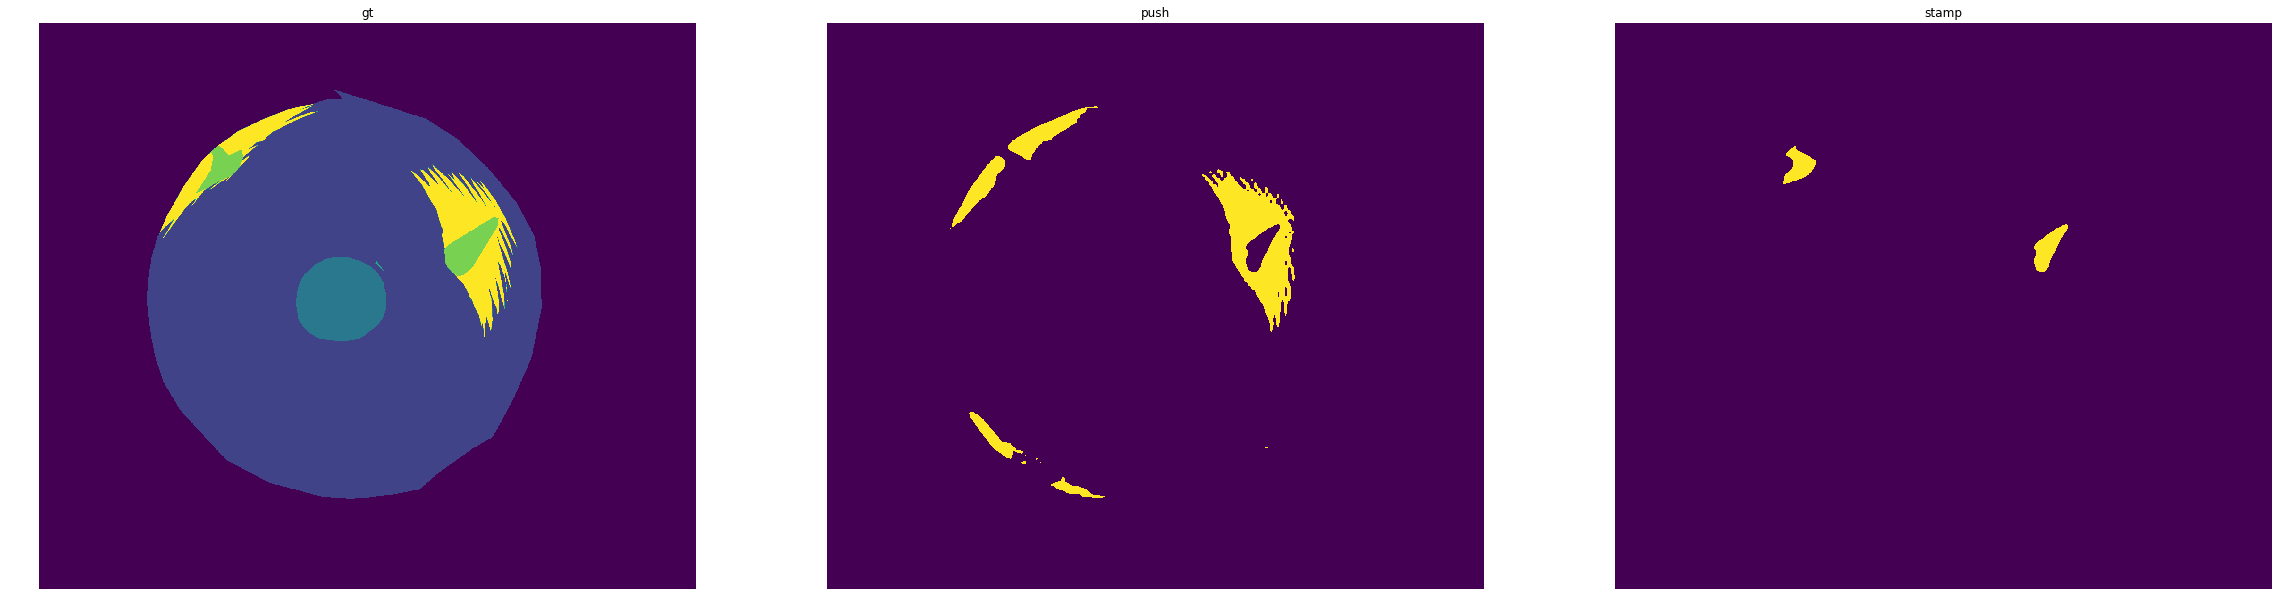

In [196]:
idx = 19

pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,5
# 0 bg, 1 Circle 2 hole 3 small 4 stamp 5 psuhed 

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,5], -1) # stamped = H,W,1
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
small = tf.expand_dims(ex[:,:,3], -1)

#bg = 0, pushed = 1, stamped = 2, circle = 3

gt_mask = np.round(test_y[idx],decimals = 0)
#print((gt_mask==1).sum())

display([gt_mask, pushed, stamped], fig_size=40, title=['gt','push','stamp'])

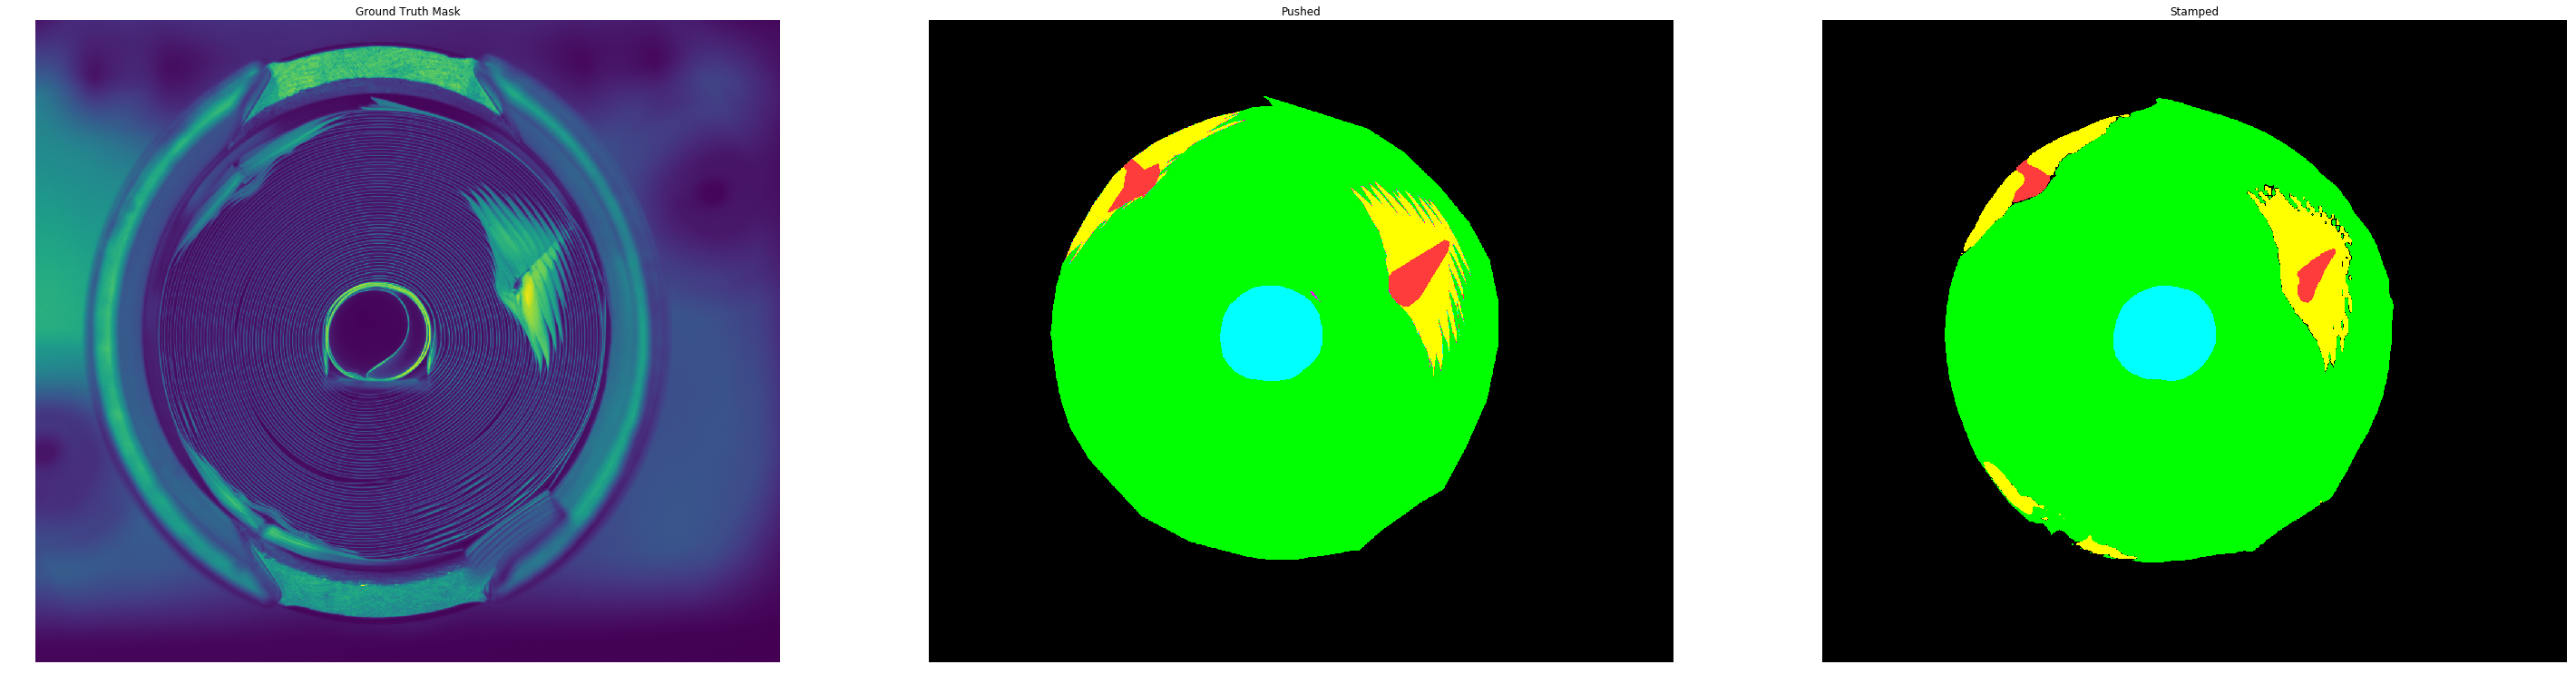

In [197]:
channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
channel_1 = np.zeros(IMG_SIZE+(1,))
channel_2 = np.zeros(IMG_SIZE+(1,))

# 0 bg, 1 Circle 2 hole 3 small 4 stamp 5 psuhed 

channel_0[pushed==1] = orig_color_dict[5][0]
channel_1[pushed==1] = orig_color_dict[5][1]
channel_2[pushed==1] = orig_color_dict[5][2]

channel_0[circle==1] = orig_color_dict[1][0]
channel_1[circle==1] = orig_color_dict[1][1]
channel_2[circle==1] = orig_color_dict[1][2]

channel_0[stamped==1] = orig_color_dict[4][0]
channel_1[stamped==1] = orig_color_dict[4][1]
channel_2[stamped==1] = orig_color_dict[4][2]

channel_0[bg==1] = orig_color_dict[0][0]
channel_1[bg==1] = orig_color_dict[0][1]
channel_2[bg==1] = orig_color_dict[0][2]

channel_0[hole==1] = orig_color_dict[2][0]
channel_1[hole==1] = orig_color_dict[2][1]
channel_2[hole==1] = orig_color_dict[2][2]

channel_0[small==1] = orig_color_dict[3][0]
channel_1[small==1] = orig_color_dict[3][0]
channel_2[small==1] = orig_color_dict[3][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)

display([test_x[idx],onehot_to_rgb(gt_mask), com],fig_size=50)

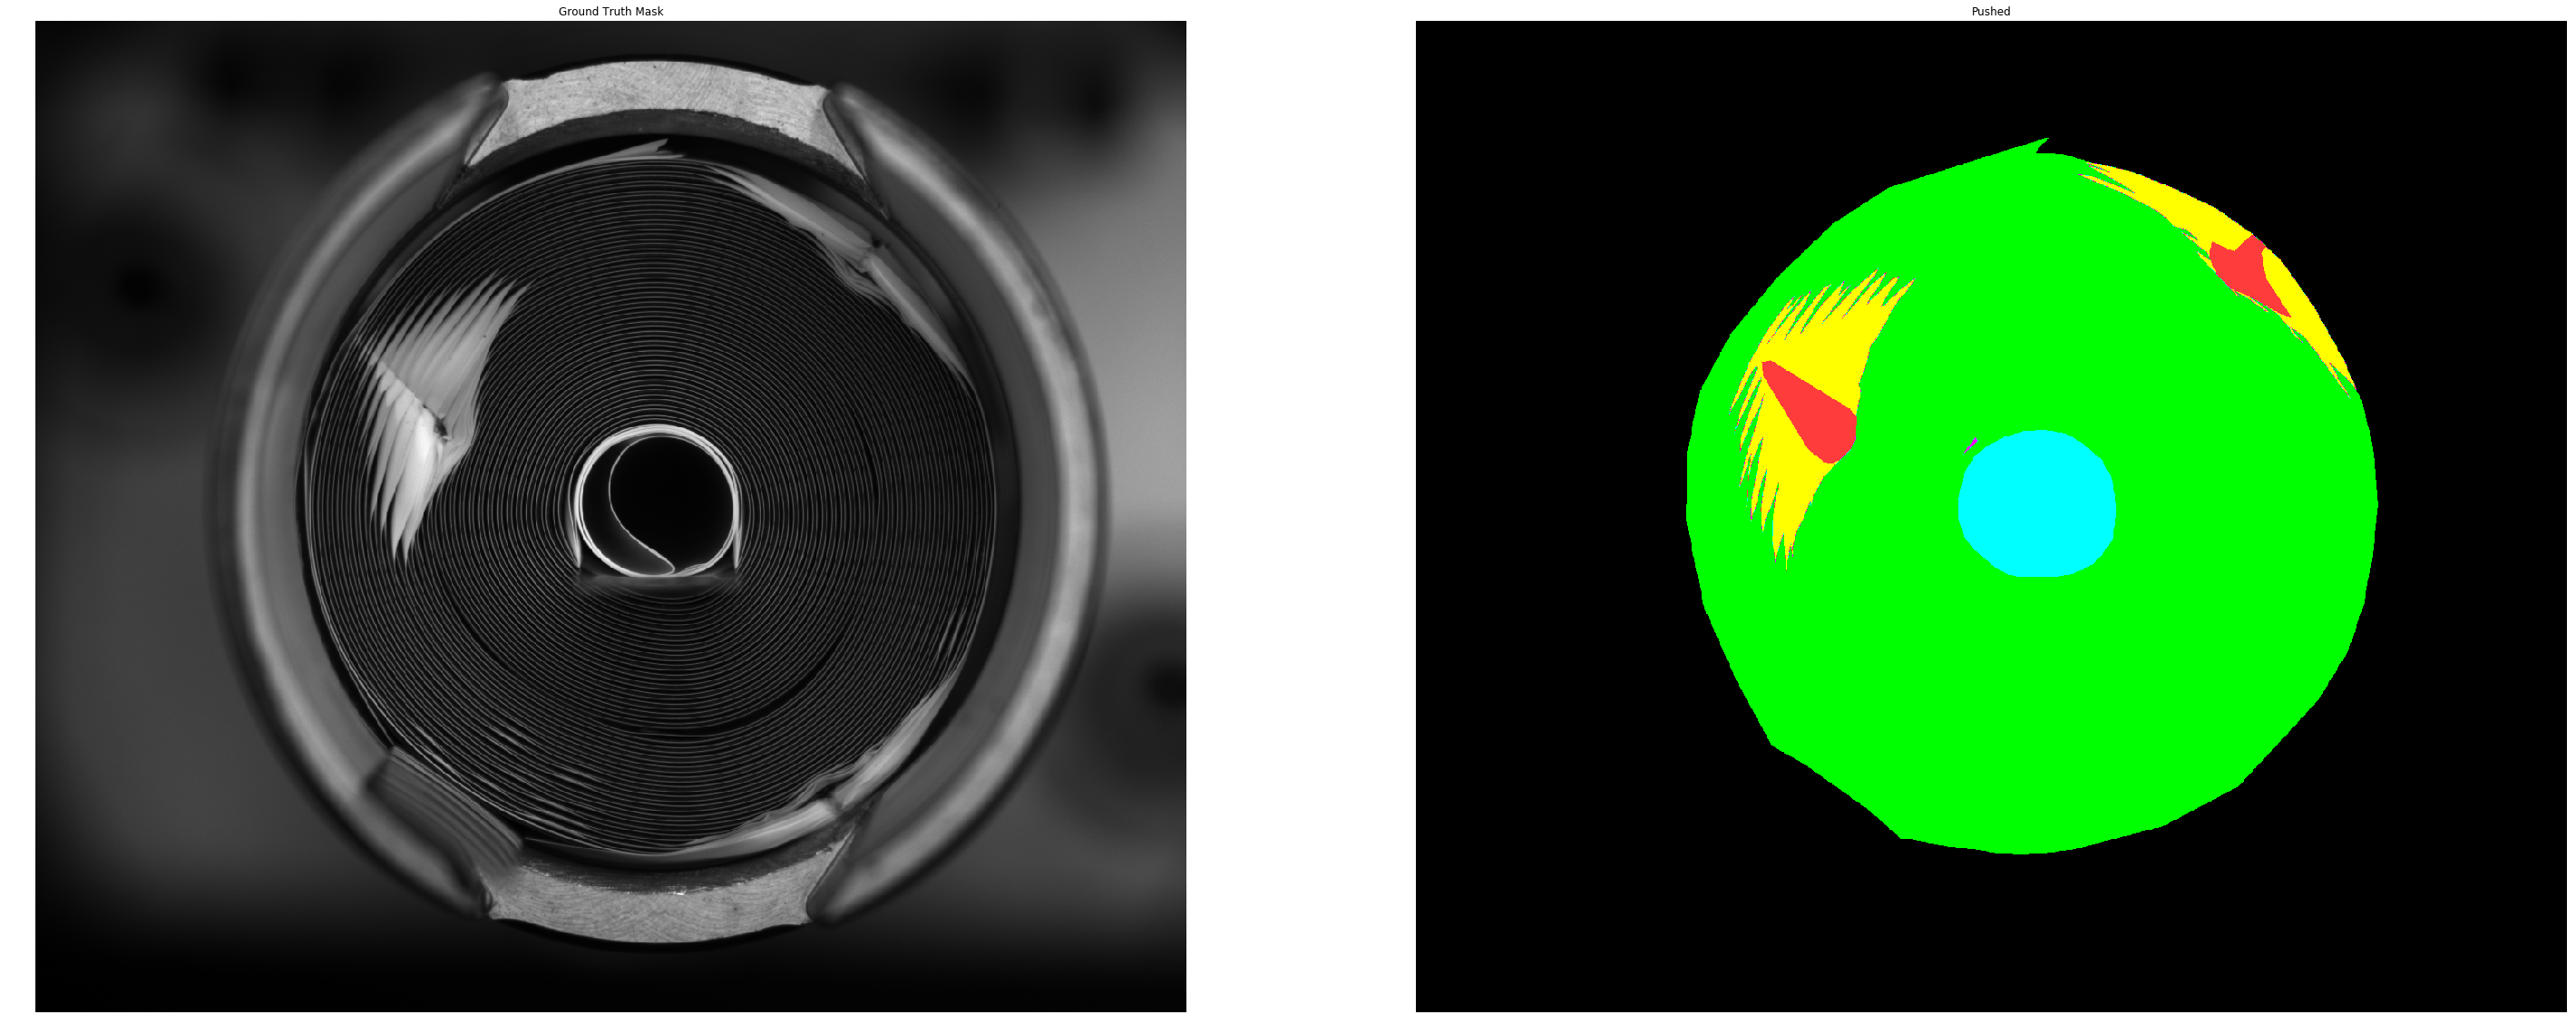

In [277]:
idx = 19


gt_mask = np.round(test_y[idx],decimals = 0)

display([tf.image.flip_left_right(tf.image.grayscale_to_rgb(test_x[idx])),tf.image.flip_left_right(onehot_to_rgb(gt_mask))], fig_size=50)

In [198]:
img1 = np.array(tf.image.grayscale_to_rgb(test_x[idx]),np.float64)
img2 = np.array(com, np.float64)
print(img1.shape, img2.shape)

(1200, 1392, 3) (1200, 1392, 3)


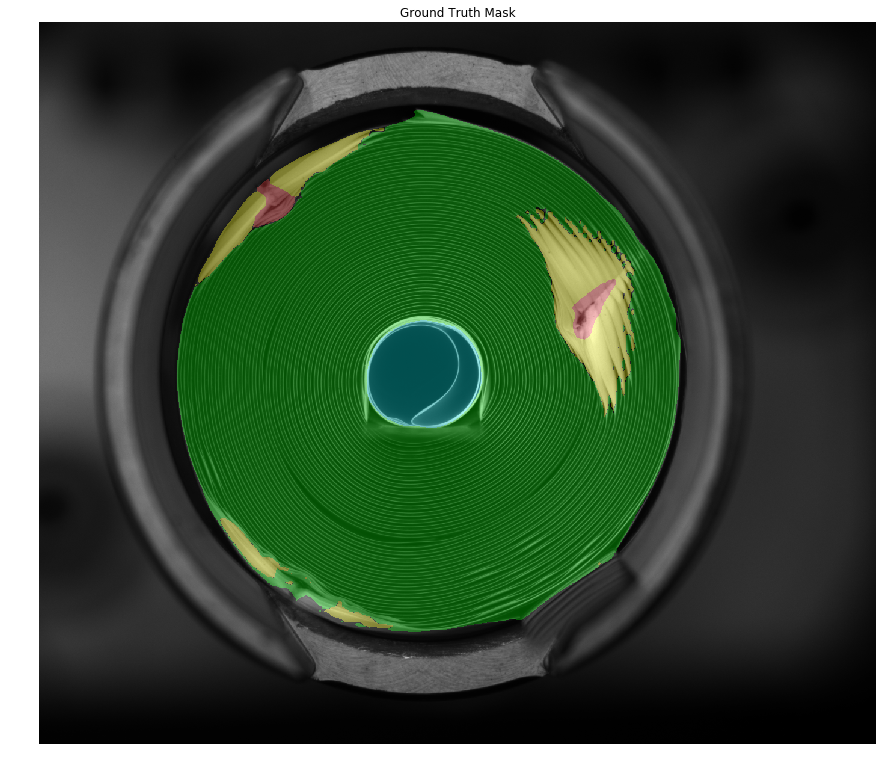

In [199]:
alpha = 0.7

#blended = img1 * 0.5  + img2*0.5
#print(blended.shape)
blended = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended])

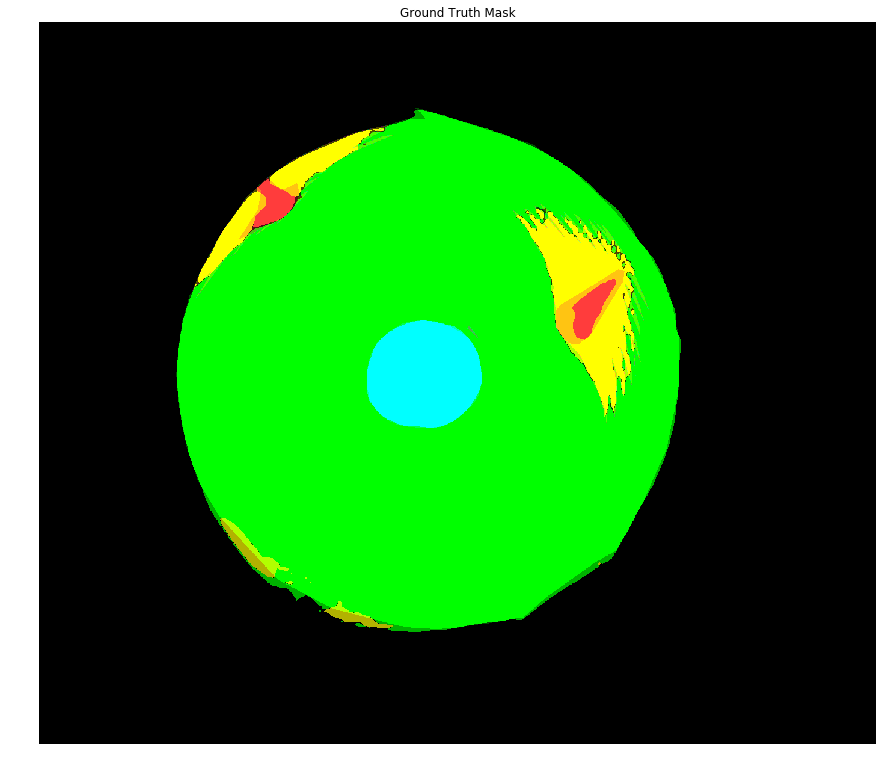

In [200]:
img1 = np.array(onehot_to_rgb(gt_mask))
img2 = np.array(com)

alpha = 0.3

#blended = img1 * 0.5  + img2*0.5
#print(blended.shape)
blended = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended])


In [168]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    
    channel_0[ex==5] = color_dict[5][0]
    channel_1[ex==5] = color_dict[5][1]
    channel_2[ex==5] = color_dict[5][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)
    
    return com

In [21]:
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)
orig_color_dict = {i: list(x) for i,x in enumerate(colors)}

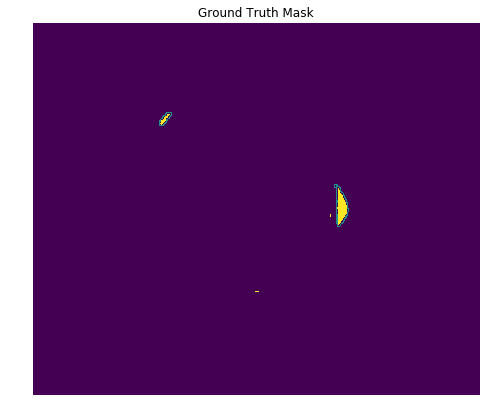

2 stamp found. Area: [2176.5, 537.0]


In [57]:
stamped_x = np.array(stamped).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed_stamp = cv2.dilate(stamped_x, k)

contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(stamped_x, contours, label="stamp")

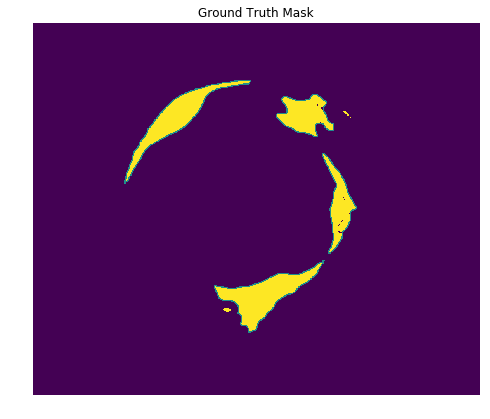

4 push found. Area: [16076.0, 7929.5, 9362.5, 13912.0]


In [58]:
pushed_x = np.array(pushed).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(pushed_x, contours, label='push', draw_type='contour')

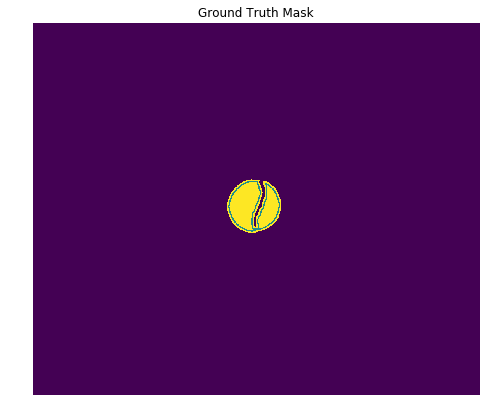

1 hole found. Area: [10572.0]


In [59]:
hole = np.array(hole).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
closing = cv2.erode(hole, k)

contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(hole, contours, label='hole', draw_type='contour')

In [28]:
"""
channel_0 = np.zeros((480,576,1)) #prediction
channel_1 = np.zeros((480,576,1))
channel_2 = np.zeros((480,576,1))

channel_0[pushed==1] = color_dict[1][0]
channel_1[pushed==1] = color_dict[1][1]
channel_2[pushed==1] = color_dict[1][2]

channel_0[circle==1] = color_dict[3][0]
channel_1[circle==1] = color_dict[3][1]
channel_2[circle==1] = color_dict[3][2]

channel_0[stamped==1] = color_dict[2][0]
channel_1[stamped==1] = color_dict[2][1]
channel_2[stamped==1] = color_dict[2][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)


display(com, idx, only_inference=True)
"""

'\nchannel_0 = np.zeros((480,576,1)) #prediction\nchannel_1 = np.zeros((480,576,1))\nchannel_2 = np.zeros((480,576,1))\n\nchannel_0[pushed==1] = color_dict[1][0]\nchannel_1[pushed==1] = color_dict[1][1]\nchannel_2[pushed==1] = color_dict[1][2]\n\nchannel_0[circle==1] = color_dict[3][0]\nchannel_1[circle==1] = color_dict[3][1]\nchannel_2[circle==1] = color_dict[3][2]\n\nchannel_0[stamped==1] = color_dict[2][0]\nchannel_1[stamped==1] = color_dict[2][1]\nchannel_2[stamped==1] = color_dict[2][2]\n\nchannel_0[bg==1] = color_dict[0][0]\nchannel_1[bg==1] = color_dict[0][1]\nchannel_2[bg==1] = color_dict[0][2]\n\ncom = tf.concat([channel_0, channel_1, channel_2], -1)\n\n\ndisplay(com, idx, only_inference=True)\n'

In [281]:
def class_iou(gt_mask, prediction, cls = 0, metric = 'iou'):
    """
    Returns IoU score if metric == 'iou', Accuracy if metric == 'acc'
    Accuracy not recommended for evaluating segmentation task
    """
    a = np.zeros(IMG_SIZE + (1,))
    a[gt_mask==cls] = 1
    
    if metric == 'iou':
        iou = tf.keras.metrics.MeanIoU(num_classes=2)
        iou.update_state(a, prediction)
        return(iou.result().numpy())
    
    elif metric == 'acc':
        m = tf.keras.metrics.Accuracy()
        weight = np.zeros(a.shape)
        weight[gt_mask==cls] = 1

        m.update_state(a, prediction, sample_weight = weight)
    
        return(m.result().numpy())


bg_iou = []
push_iou = []
stamp_iou = []
circle_iou = []
hole_iou = []
small_iou = []

bg_acc = []
push_acc = []
stamp_acc = []
circle_acc = []
hole_acc = []
small_acc = []



for idx in range(30):
    ex = np.round(pred_mask[idx][0][0]) # ex = H,W,4
    
    circle = tf.expand_dims(ex[:,:,1], -1)
    pushed = tf.expand_dims(ex[:,:,5], -1) # stamped = H,W,1
    bg = tf.expand_dims(ex[:,:,0], -1)
    hole = tf.expand_dims(ex[:,:,2], -1)
    stamped = tf.expand_dims(ex[:,:,4], -1)
    small = tf.expand_dims(ex[:,:,3], -1)

    gt_mask = np.round(test_y[idx],decimals = 0)
    
    bg_acc.append(class_iou(gt_mask, bg, cls=0, metric='acc'))
    push_acc.append(class_iou(gt_mask, pushed, cls=5, metric='acc'))
    circle_acc.append(class_iou(gt_mask, circle, cls=1, metric='acc'))
    stamp_acc.append(class_iou(gt_mask, stamped, cls=4, metric='acc'))
    hole_acc.append(class_iou(gt_mask, hole, cls=2, metric='acc'))
    small_acc.append(class_iou(gt_mask, small, cls=3, metric='acc'))
    
    bg_iou.append(class_iou(gt_mask,bg,cls=0))
    push_iou.append(class_iou(gt_mask, pushed, cls=5))
    circle_iou.append(class_iou(gt_mask,circle,cls=1))
    stamp_iou.append(class_iou(gt_mask, stamped, cls=4))
    hole_iou.append(class_iou(gt_mask,hole,cls=2))
    small_iou.append(class_iou(gt_mask,small,cls=3))
    
print("Background IoU:", np.mean(bg_iou), "Background Accuracy:", np.mean(bg_acc)) #0.986
print("Push IoU:", np.mean(push_iou), "Push Accuracy:", np.mean(push_acc)) #0.664
print("Circle IoU:", np.mean(circle_iou), "Circle Accuracy:", np.mean(circle_acc)) #0.544
print("Stamp IoU:", np.mean(stamp_iou), "Stamp Accuracy:", np.mean(stamp_acc)) 
print("Hole IoU:", np.mean(hole_iou), "Hole Accuracy:", np.mean(hole_acc)) 
print("Small IoU:", np.mean(small_iou), "Small Accuracy:", np.mean(small_acc)) 

Background IoU: 0.99411213 Background Accuracy: 0.99791414
Push IoU: 0.85041815 Push Accuracy: 0.6813103
Circle IoU: 0.9869672 Circle Accuracy: 0.99443555
Stamp IoU: 0.7758548 Stamp Accuracy: 0.4076479
Hole IoU: 0.9523421 Hole Accuracy: 0.9083042
Small IoU: 0.49980274 Small Accuracy: 0.0


In [306]:
def get_iou(test_y, cls): #0:bg 1:circle 2:hole 3:small 4:stamped 5:pushed
    iou = []
    fn_r = []
    fp_r = []
    
    for idx in range(80):
        ex = np.round(pred_mask[idx][0][0]) # ex = H,W,4

        y_pred = tf.expand_dims(ex[:,:,cls], -1)

        gt_mask = np.round(test_y[idx],decimals = 0)
        if cls not in np.unique(gt_mask): continue
            
        y_true = np.zeros(IMG_SIZE + (1,))
        y_true[gt_mask == cls] = 1

        FP = len(np.where(y_pred - y_true  == -1)[0])
        FN = len(np.where(y_pred - y_true  == 1)[0])
        TP = len(np.where(y_pred + y_true ==2)[0])
        TN = len(np.where(y_pred + y_true == 0)[0])
        
        cmat = [[TP, FN], [FP, TN]]
        
        if TP+FN+FP == 0 or FN+TP ==0 or FP+TN==0: 
            continue
            
        fn_r.append(FN/(FN+TP))
        fp_r.append(FP/(FP+TN))
        iou.append (TP/(TP+FN+FP))
        
    
    return (np.mean(iou), np.mean(fn_r), np.mean(fp_r) )
        
stamp_iou, stamp_fnr, stamp_fpr = get_iou(test_y, cls=4)
pushed_iou, pushed_fnr, pushed_fpr = get_iou(test_y, cls=5)
circle_iou, circle_fnr, circle_fpr = get_iou(test_y, cls=1)


In [307]:
print("STAMP IoU: {}, FNR: {}, FPR: {}".format(stamp_iou, stamp_fnr, stamp_fpr))
print("PUSHED IoU: {}, FNR: {}, FPR: {}".format(pushed_iou, pushed_fnr, pushed_fpr))
print("CIRCLE IoU: {}, FNR: {}, FPR: {}".format(circle_iou, circle_fnr, circle_fpr))

STAMP IoU: 0.3863517187268232, FNR: 0.3340508086934517, FPR: 0.0020823034947655855
PUSHED IoU: 0.7017744085017331, FNR: 0.10697883048526122, FPR: 0.007632423377338638
CIRCLE IoU: 0.97918956316184, FNR: 0.015428910032646204, FPR: 0.002116675928019122
